## Assignment 3:Apply k-NN on Amazon reviews data-set [M]


Given Dataset consists of reviews of fine foods from amazon. Reviews describe
    (1)product and user information
    (2)ratings
    (3) a plain text review.
 
K-NN is used for classification and regression for data.Here, K-NN algorithm is applied on amazon reviews datasets to classify postive and negative reviews.

Procedure to execute the above task is as follows:

* Data Pre-processing is applied on given amazon reviews data-set.
* Take sample of data from dataset because of computational limitations
* apply  Feature generation techniques(Bow,tfidf,avg w2v,tfidfw2v) 
* Apply K-NN algorithm using each technique and find best accuracy


## Objective:

* To classify given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2)) using k-NN algorithm(brute force and kd tree).
* To train and test split data using Time based slicing
* To find optimal 'k' in knn using TimeSeriesSplit(Bow,tfidf,avg w2v,tfidfw2v)
* To calcuate Test accuracy:Best 'k'
* Comapare the results using brute force and kd tree





In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

In [2]:
# All necessary module

#import  sys
import re
import math
import sqlite3
import pandas as pd
import numpy as np
import pickle
# modules for text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
import pytablewriter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# knn modules
# train-split data,accuracy-score,cross-validation modules

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import cKDTree
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import zipfile
archive = zipfile.ZipFile('/floyd/input/pri/Reviews.zip', 'r')
csvfile = archive.open('Reviews.csv')

In [4]:
# Reading CSV file and printing first five rows 
amz = pd.read_csv(csvfile ) # reviews.csv is  dataset file
print(amz.head())


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [5]:
# dimensions of dataset and columns name

print(amz.shape) 
#print(amz1.shape)
print(amz.columns)
amz=amz.fillna(lambda x: x.median())

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


The amazon reviews datafile contains 568454 rows of entry and 10 columns.For given objective, processing of data is necessary."Score" and "text" columns is processed for required result.

##### Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating. If score is equal to 3,it is considered as neutral score.

In [6]:
# Processing
#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def score_part(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = amz['Score']
#print(actualScore)
New_score = actualScore.map(score_part)
#print(New_score)
amz['Score']=New_score

# If score is equal to 3,it is considered as neutral score.

    






In [7]:
print(amz.shape)
amz.head(5)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Data Pre-processing on raw data:

Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.


In [8]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(5))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

            Id   ProductId          UserId  \
171222  171223  7310172001   AJD41FBJD9010   
171153  171154  7310172001   AJD41FBJD9010   
171151  171152  7310172001   AJD41FBJD9010   
217443  217444  7310172101  A22FICU3LCG2J1   
217444  217445  7310172101  A1LQV0PSM04DWI   

                                         ProfileName  HelpfulnessNumerator  \
171222  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
171153  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
171151  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
217443                                      C. Knapp                     1   
217444                                 B. Feuerstein                     1   

        HelpfulnessDenominator     Score        Time  \
171222                       1  positive  1233360000   
171153                       0  positive  1233360000   
171151                       0  positive  1233360000   
217443                       1

positive    336824
negative     57107
Name: Score, dtype: int64

List of total counts Postive score and Negative score ==> [336824, 57107]


Text(0.5,1,'Total counts of Postive score and Negative score ')

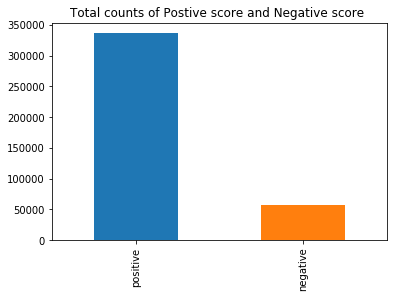

In [9]:
a=final['Score'].value_counts().tolist()
print('List of total counts Postive score and Negative score ==>',a)
final['Score'].value_counts().plot(kind='bar')
plt.title('Total counts of Postive score and Negative score ')


#### observations
* The positive reviews is greater than negative reviews.It makes data imbalanced.
* From the bar plot ,it is seen that sampled datasets of review is imbalnced.


# Text Preprocessing:

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>$< /><')
    #cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


cleaning html tags like" <.*?>" and punctuations like " r'[?|!|\'|"|#]',r''" from senetences

In [12]:
#final = final.sample(frac=0.004,random_state=1)
#print(final.shape)

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1
#print('all_positive_words =',len(all_positive_words))
#print('all_negative_words =',len(all_negative_words))

# Finding most frequently occuring Positive and Negative words 

freq_positive=nltk.FreqDist(all_positive_words)

freq_negative=nltk.FreqDist(all_negative_words)

#print("\nMost Common Positive Words : ",freq_positive.most_common(20))

#print("\nMost Common Negative Words : ",freq_negative.most_common(20))




##### Dumping and loading  Pre processing of text data in pickle file 

In [14]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [12]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [13]:

final['CleanedText']=final_string
#adding a column of CleanedText which displays the data after pre-processing of the review 
Pre_Process_Data = final[['CleanedText','Score','Time']] 

X_Text=Pre_Process_Data ['CleanedText']

Y_Score =Pre_Process_Data ['Score'] # positive or negative score
print('\nPre_Process_Text_Data  X_Text=',X_Text.shape)
print('\nPre_Process_Score_Data Y_Score=',Y_Score.shape)



Pre_Process_Text_Data  X_Text= (393931,)

Pre_Process_Score_Data Y_Score= (393931,)


In [14]:
# postive and negtive reviews from original datasets of amazon
pos_final = Pre_Process_Data[Pre_Process_Data .Score == 'positive']# postive reviews
pos_final = pos_final.sample(frac=0.3)
print(pos_final.Score.value_counts())

neg_final = Pre_Process_Data [Pre_Process_Data .Score == 'negative'] # negative reviews
print(neg_final.Score.value_counts())

positive    101047
Name: Score, dtype: int64
negative    57107
Name: Score, dtype: int64


In [15]:
final_pos_neg = pd.concat([pos_final,neg_final],axis=0)
print(len(final_pos_neg))
print(type(final_pos_neg))
#print('final_pos_neg=',final_pos_neg['Score'])

158154
<class 'pandas.core.frame.DataFrame'>


In [16]:
print(final_pos_neg.columns)

Index(['CleanedText', 'Score', 'Time'], dtype='object')


### Splitting Training and Testing dataset based on Time

In [17]:
# splitting training and testing dataset (Time based splitting)

X1 = final_pos_neg[['CleanedText','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
X=X1[:40000]

print(X.shape)
Y1 = final_pos_neg[['Score','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
Y=Y1[:40000]
print(Y.shape)
## 70 % of data

X_train_data ,X_test_data,Y_train_data,Y_test_data  = train_test_split(X,
                                                      Y.values.ravel(),
                                                                       
                                                    test_size=0.3,shuffle=False)



print('X_train_data ',X_train_data.shape)

print('X_test_data ',X_test_data.shape )

print('Y_train_data ',Y_train_data .shape)

print('Y_test_data ',Y_test_data .shape)



(40000, 1)
(40000, 1)
X_train_data  (28000, 1)
X_test_data  (12000, 1)
Y_train_data  (28000,)
Y_test_data  (12000,)


In [18]:

Y_new = Y['Score'].map(lambda x: 1 if x == 'positive' else 0).values.ravel()
# Y train and Test for sparse datasets

y_train_new,y_test_new = train_test_split(Y_new,test_size=0.3,shuffle=False)
print('y_train_new ',y_train_new.shape)

print('y_test_new ',y_test_new .shape)


y_train_new  (28000,)
y_test_new  (12000,)


#  Optimal K for KNN

In [19]:
 # Time seris splitting Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

In [20]:
# k-optimal is function to calculate the optimal k value for knn

def k_optimal(X_train,X_test):
    print('opyimal k value')
    warnings.filterwarnings("ignore")
    
    My_List = list(range(2,20)) 
    neighbors = list(filter(lambda x: x % 2 != 0, My_List))
    algorithm=['kd_tree','brute']
    global optimal_k_list
    optimal_k_list=[]
    for algo in range(len(algorithm)):
        print('algorithm = ',algorithm[algo])
        
        test_error=[]
        train_error=[]
        cv_scores = []

        for i in range(len(neighbors)):
            hp1 =dict(n_neighbors=[neighbors[i],],algorithm=[algorithm[algo],])
            knn = KNeighborsClassifier(n_jobs=-1)
            model1 = GridSearchCV(knn, hp1,
                                  scoring ='f1', 
                                  cv=tscv
                                  ,n_jobs= -1
                                  ,pre_dispatch=8)
            best_model1=model1.fit(X_train[algo], y_train_new)
            
            
            Train_score=model1.score(X_train[algo], y_train_new)
            
            train_error.append(1-Train_score)
            cv_scores.append(1-Train_score)
            Test_score=model1.score(X_test[algo],y_test_new)
            test_error.append(1-Test_score)



        MSE = [1 - x for x in cv_scores]
      
        # determining best k
        global optimal_k
        optimal_k = neighbors[MSE.index(min(MSE))]
      
        optimal_k_list.append(optimal_k)


        print('\nThe optimal number of neighbors is %d.' % optimal_k)

        fig = plt.figure( facecolor='y', edgecolor='k',figsize=(15,8))

        plt.semilogx(neighbors, MSE,'m*',linestyle='dashed', label='depthsize')
        plt.legend(loc='lower left')


        for xy in zip(neighbors, np.round(MSE,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        plt.title('Error_Rate vs. K_Value')
        plt.grid()
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error')
        plt.show()

        print("the misclassification error for each k value is : ", np.round(MSE,5))

        fig = plt.figure( facecolor='y', edgecolor='k')
        plt.semilogx(neighbors,train_error,'g*',linestyle='dashed', label='Train')
        plt.semilogx(neighbors,test_error,'r*', linestyle='dashed',label='Test')
        plt.legend(loc='lower left')
        plt.grid()

        plt.xlabel('K neighbors  ')
        plt.ylabel('Performance using '+str(algorithm[algo]))
        plt.show()


In [42]:
# k-optimal is function to calculate the optimal k value for knn 
# using Multiprocessing
import multiprocessing as mp


def main():
    print("Started.")

    k_optimal(xtrain,xtest)
   



k-optimal is function to calculate the optimal k value for knn.

##### Pandas dataframe to markdown Table format

In [43]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()


    

# Methods to convert text into vector

Methods:
* Bag of Words
* Avg word2vec
* Tf-idf
* tf-idf weighted Word2Vec

Using above four method is used to convert text to numeric vector.

# 1. Bag of Words (BoW)

##### BOW for Training Data

In [29]:
count_vect = CountVectorizer() #in scikit-learn
vect_Data = count_vect.fit_transform(X_train_data.values.ravel())
print(vect_Data .shape)

(28000, 20590)


In [30]:
# truncated SVD for dimesionality reduction for 100 dimensions
svd = TruncatedSVD(n_components=100,n_iter=7)

Data=svd.fit_transform(vect_Data )
print("TruncatedSVD :",Data.shape)


TruncatedSVD : (28000, 100)


In [31]:
# StandardScaler
sc_data= StandardScaler(with_mean=False).fit_transform(Data )
final_data= preprocessing.normalize(sc_data)
print(final_data.shape)
#Normalize Data


warnings.filterwarnings("ignore")    

(28000, 100)


#### Dumping & Loading Pickle file for training data ( BOW )


In [32]:
#Pickle file for training data

pickle_path_BOW_train='X_train_data_BOW.pkl'
X_train_data_BOW=open(pickle_path_BOW_train,'wb')
pickle.dump(final_data ,X_train_data_BOW)
X_train_data_BOW.close()


In [33]:
pickle_path_BOW_train='X_train_data_BOW.pkl'
unpickle_path1=open(pickle_path_BOW_train,'rb')
final_data=pickle.load(unpickle_path1)

##### Sparse matrix for train Data (KD-Tree)

In [34]:
final_data_sparse=csr_matrix(Data).todense()
#final_data_sparse = preprocessing.normalize(final_data_sparse1)
print("Train data Sparse:",final_data_sparse)

Train data Sparse: [[ 0.88923011 -0.23770002  0.15238884 ... -0.33439129 -0.18310113
   0.07761813]
 [ 0.52521297 -0.07851448  0.03767966 ...  0.19579533  0.12882225
  -0.18778595]
 [ 0.47455633 -0.1354722   0.06045515 ...  0.03616926 -0.02312829
   0.04665366]
 ...
 [ 0.94256057 -0.31561972 -0.02754873 ...  0.0648032  -0.18641765
   0.02396582]
 [ 1.21033516 -0.3813755   0.30442384 ... -0.21936339 -0.0671804
   0.05819784]
 [ 4.32335934 -1.38510882 -0.87885423 ... -0.27533609 -0.03328312
  -0.2384029 ]]


##### BOW for Testing Data

In [35]:
vect_Data1= count_vect.transform(X_test_data.values.ravel())
print(vect_Data1.shape)

svd1 = svd.fit(vect_Data1)

X_test=svd1.transform(vect_Data1)
print("TruncatedSVD :",X_test.shape)
#Normalize Data
#X_sparse_tsvd = svd.fit(vect_Data1).transform(X_sparse)

(12000, 20590)
TruncatedSVD : (12000, 100)


In [36]:
#final_data_test= bb.fit(data1 )
final_data_test_f=StandardScaler(with_mean=False).fit(X_test)
print(final_data_test_f)

final_data_test1=final_data_test_f.transform(X_test)
final_data_test= preprocessing.normalize(final_data_test1)


StandardScaler(copy=True, with_mean=False, with_std=True)


#### Dumping & Loading Pickle file for testing data ( BOW) 

In [37]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
X_test_data_BOW=open(pickle_path_BOW_test,'wb')
pickle.dump(final_data_test ,X_test_data_BOW)
X_test_data_BOW.close()

In [38]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
unpickle_path2=open(pickle_path_BOW_test,'rb')
final_data_test=pickle.load(unpickle_path2)

In [ ]:
##### Sparse matrix for test data(KD-Tree)

In [39]:
final_data_test_sparse=csr_matrix(final_data_test ).todense()
#final_data_test_sparse= preprocessing.normalize(final_data_test_sparse)
print("Test Data Sparse:",final_data_test_sparse.shape)

Test Data Sparse: (12000, 100)


 Featured data of Bag of words is Standardization (mean=0 and std.dev=1).

### Optimal k using BOW

Started.
opyimal k value
algorithm =  kd_tree

The optimal number of neighbors is 19.


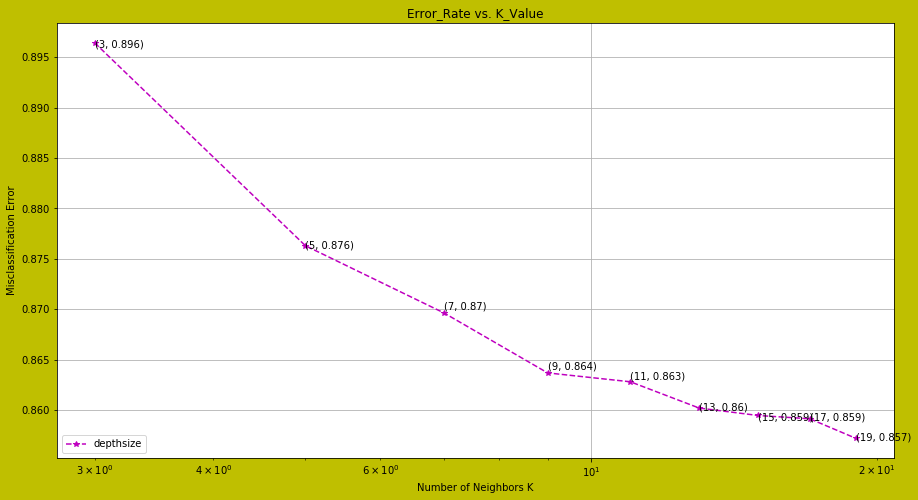

the misclassification error for each k value is :  [0.89642 0.87631 0.86964 0.86369 0.86281 0.86021 0.85947 0.85914 0.85722]


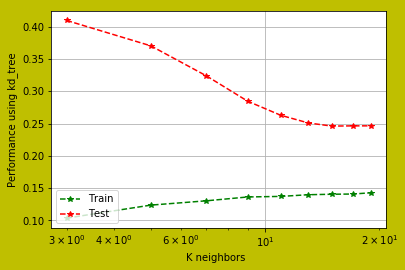

algorithm =  brute

The optimal number of neighbors is 19.


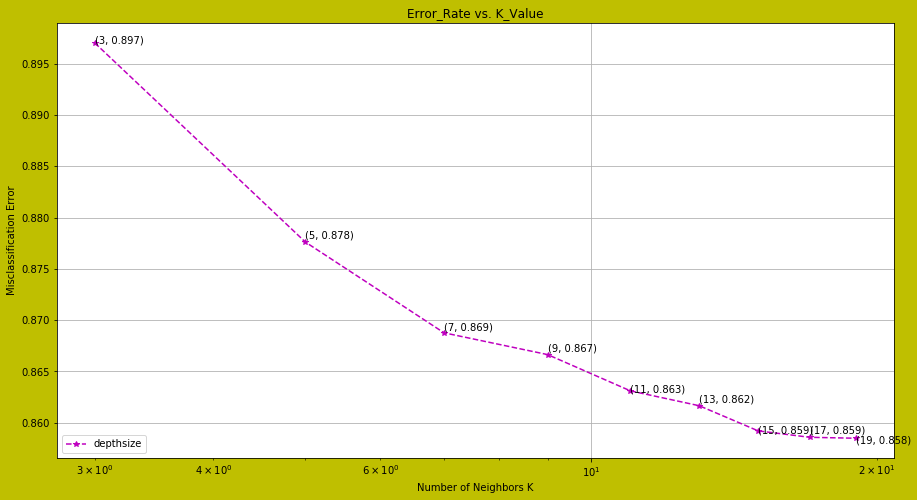

the misclassification error for each k value is :  [0.89705 0.87762 0.86877 0.86664 0.86311 0.86166 0.8592  0.85858 0.85849]


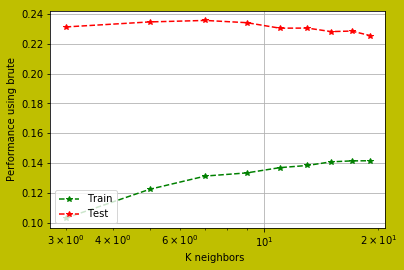

In [37]:
# To get optimal k using BOW

if __name__=='__main__':
    mp.freeze_support()
   
    xtrain=[final_data_sparse,final_data]
    xtest=[final_data_test_sparse,final_data_test]

    main()
    
    






In [38]:
print(optimal_k_list)

[19, 19]


#### Observations:
* The optimal number of neighbors is 19 for both KD_tree KNN and Brute KNN
* Error rate vs K value graph is shown as above.
* From the graph, misclassification error is low for higher k values.
* As k values increases from 1 to 20, MSE  decreses and then remains constant.
* at k=19 , MSE is lower than other value for both the implementations.
* Training and testing error plot is shown for KD-Tree and Brute KNN.


## Knn classifier  for optimal k value
All techniques for Scoring metrics and confusion matrix are shown as below

In [26]:
models_performence = {
    'Model':[],    
    'Vectorizer': [],
    'algorithm':[],
    'Optimal k': [],
    'Train error':[],
    'Test error':[],
    'Accuracy':[],
    'F1':[],
    'recall':[],
    'precision':[]
    
  
}
columns = ["Model", "Vectorizer","algorithm","Optimal k", "Train error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
pd.DataFrame(models_performence, columns=columns)

,Model,Vectorizer,algorithm,Optimal k,Train error,Test error,Accuracy,F1,recall,precision


### KNN Classifier 


In [27]:
#  Knn classifier 
def Knn_classifier_optimal_k(xtrain,ytrain,xtest,ytest,k,algo,vectorization):
    
    warnings.filterwarnings("ignore")
    
    print(' Algorithm = '+str(algo))
    
    models_performence['Model'].append('KNN')
    models_performence['Vectorizer'].append(vectorization)
    models_performence['algorithm'].append(algo)
    models_performence['Optimal k'].append(k)
    #
    knn = KNeighborsClassifier(n_neighbors=k,
                               algorithm=algo,
                               metric='euclidean',
                               n_jobs=-1)
    
    model=knn.fit(xtrain,ytrain)
    prediction =  model.predict(xtest)
   
    #Training accuracy and training error
    
    training_score=knn.score(xtrain,ytrain)
    print('training accuracy=',training_score)
    
    
    training_error=1-training_score
    print('training error is =',training_error)
    models_performence['Train error'].append(training_error)
    
    # Testing Accuracy and testing error for knn model

    Testing_score=round(accuracy_score(ytest,prediction),5)
    print("Accuracy for KNN model  is = ",Testing_score)
    models_performence['Accuracy'].append(Testing_score)
    
    Testing_error=1-Testing_score
    print("Testing error for KNN model is = ",Testing_error)
    models_performence['Test error'].append(Testing_error)
    
    F1_score = round(f1_score(ytest ,prediction,average='macro'),5)*100
    models_performence['F1'].append(F1_score)
    
    recall = round(recall_score(ytest,prediction,average='macro'),5)*100
    models_performence['recall'].append(recall)
    
    precision = round(precision_score(ytest,prediction,average='macro'),5)*100
    models_performence['precision'].append(precision)
    
    print('\n')
    print(classification_report( ytest,prediction))
    
    cm = confusion_matrix( ytest,prediction)
    label = ['negative', 'positive']
    df_conf = pd.DataFrame(cm, index = label, columns = label)
    sns.heatmap(df_conf, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


## Knn classifier  for optimal k value ( BOW)
All techniques for Scoring metrics and confusion matrix are shown as below

In [41]:
xtrain=[final_data_sparse,final_data]
ytrain=[y_train_new,Y_train_data]

xtest=[final_data_test_sparse,final_data_test]
#xtest=final_data_test
ytest=[y_test_new,Y_test_data]
vectorization='BOW'

k=optimal_k_list



Started.
Algorithm is =['kd_tree', 'brute'] for optimal k =19
 Algorithm = kd_tree
training accuracy= 0.7801785714285714
training error is = 0.2198214285714286
Accuracy for KNN model  is =  0.62692
Testing error for KNN model is =  0.37307999999999997


             precision    recall  f1-score   support

          0       0.36      0.17      0.23      3934
          1       0.68      0.85      0.75      8066

avg / total       0.57      0.63      0.58     12000



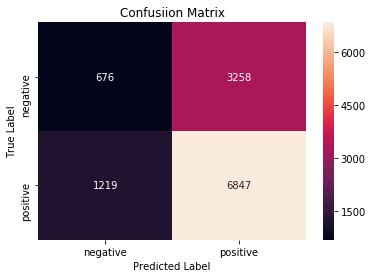

Algorithm is =['kd_tree', 'brute'] for optimal k =19
 Algorithm = brute
training accuracy= 0.7787857142857143
training error is = 0.2212142857142857
Accuracy for KNN model  is =  0.64375
Testing error for KNN model is =  0.35624999999999996


             precision    recall  f1-score   support

   negative       0.35      0.10      0.15      3934
   positive       0.67      0.91      0.77      8066

avg / total       0.57      0.64      0.57     12000



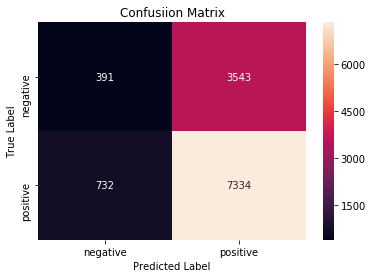

In [42]:
import multiprocessing as mp


def main1():
    print("Started.")
    algorithm=['kd_tree','brute']
  
    for i in range(len(algorithm)):
        algo=algorithm[i]
        print("Algorithm is ="+str(algorithm)+" for optimal k ="+str(k[i]))

        Knn_classifier_optimal_k(xtrain[i],ytrain[i],xtest[i],ytest[i],k[i],algo,vectorization)

if __name__=='__main__':
    mp.freeze_support()
    main1()
   


In [43]:
df2=pd.DataFrame(models_performence, columns=columns)
result_display(df2)

|Model|Vectorizer|algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|----------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW       |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW       |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|



|Model|Vectorizer|algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|----------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW       |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW       |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|

#### observations
* The optimal number of neighbors is 19 for both the algorithm.
* True postive rate   is high(91%) for Brute force and 85% for KD-Tree.It means postive rating is higher as compared to negative rating which is good for amazon reviews .
* Confusion matrix and model performance is shown as above.
* FNR is higher in both Algorithm.
* KDTree Algorithm for KNN classifier is giving better performance as compared to brute Algorithm  as seen in above table



 

# 2. Avg word2vec
Firstly, word2vec model is designed for amazon reviews using gensim module.

In [44]:
import gensim
list_sent=[]
for text in X_train_data.values.ravel(): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent.append(filter_text)
print(len(list_sent))


    

28000


##### word2vec Model using Training Datasets

In [45]:

w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=100, workers=4) 
#this model is used in avg word2vec  .  


In [46]:
pickle_path_w2v_model='w2v_model.pkl'
w2v_model_path=open(pickle_path_w2v_model,'wb')
pickle.dump(w2v_model,w2v_model_path)
w2v_model_path.close()

In [47]:
pickle_path_w2v_model='w2v_model.pkl'
unpickle_w2v_model=open(pickle_path_w2v_model,'rb')
w2v_model=pickle.load(unpickle_w2v_model)

In [48]:
words = list(w2v_model.wv.vocab)
print(len(words))
#print(w2v_model['use'])

7263


#### Avg Word2Vec 

In [49]:
#  For Training

sent_vectors = []
for sent in list_sent: # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


print(len(sent_vectors))

#print(sent_vectors[0:4])




28000


In [50]:
# Converting Nan value to zero in sent vectors.
Sent_Nan = np.where(np.isnan(sent_vectors), 0, sent_vectors)



In [51]:
# converting sent list to nd array
Sent_final_vector = np.asarray(Sent_Nan )
print(type(Sent_final_vector))


<class 'numpy.ndarray'>


In [52]:
#  ForTesting
# Words in test reviews
list_sent_test=[]
for text in X_test_data.values.ravel(): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent_test.append(filter_text)
#print(len(list_sent_test))

sent_vectors1 = []
for sent in list_sent_test: # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)


print(len(sent_vectors1))

#print(sent_vectors1)
# Converting Nan value to zero in sent vectors.
Sent_Nan1 = np.where(np.isnan(sent_vectors1), 0, sent_vectors1)

# converting sent list to nd array
Sent_final_vector1 = np.asarray(Sent_Nan1)
print(type(Sent_final_vector1))



12000
<class 'numpy.ndarray'>


#### Dumping & Loading Pickle file for  Avg word2vec

In [53]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
X_data_AW2V_train=open(pickle_path_AW2V_train,'wb')
pickle.dump(Sent_final_vector,X_data_AW2V_train)
X_data_AW2V_train.close()

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
X_data_AW2V_test=open(pickle_path_AW2V_test,'wb')
pickle.dump(Sent_final_vector1,X_data_AW2V_test)
X_data_AW2V_test.close()


In [54]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
unpickle_path3_train=open(pickle_path_AW2V_train,'rb')
Sent_final_vector=pickle.load(unpickle_path3_train)

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
unpickle_path3_test=open(pickle_path_AW2V_test,'rb')
Sent_final_vecto1=pickle.load(unpickle_path3_test)

##### Standardscaler & normalizing training avg word2vec

In [55]:
sc_data1= StandardScaler(with_mean=False).fit_transform(Sent_final_vector)
# For Train
final_w2v_count_Train=preprocessing.normalize(sc_data1)
print(final_w2v_count_Train.shape)

(28000, 100)


##### Sparse Matrix for training Avg word2vec

In [56]:
final_w2v_count_Train_sparse=csr_matrix(Sent_final_vector).todense()

print("Train data Sparse:",final_w2v_count_Train_sparse.shape)

Train data Sparse: (28000, 100)


##### Standardscaler & normalizing testing avg word2vec

In [57]:
sc_avgword2vec=StandardScaler(with_mean=False).fit(Sent_final_vector1)
print(sc_avgword2vec)

sc_avgword2vec1=sc_avgword2vec.transform(Sent_final_vector1)

StandardScaler(copy=True, with_mean=False, with_std=True)


In [58]:

final_w2v_count_Test=preprocessing.normalize(sc_avgword2vec1)# For Test
print(final_w2v_count_Test.shape)


(12000, 100)


In [59]:
final_w2v_count_Test_sparse=csr_matrix(Sent_final_vector1).todense()

print("Test Data Sparse:",final_w2v_count_Test_sparse.shape)

Test Data Sparse: (12000, 100)


##### for Training datasets ,avg word2vec 
                 final_w2v_count_Train,                 
                 final_w2v_count_Train_sparse
   
##### for testing datasets ,avg word2vec 
                 final_w2v_count_Test, 
                 final_w2v_count_Test_sparse

### Optimal k for Avg word2vec

In [60]:
# To get optimal k using  Avg word2vec


Started.
opyimal k value
algorithm =  kd_tree

The optimal number of neighbors is 19.


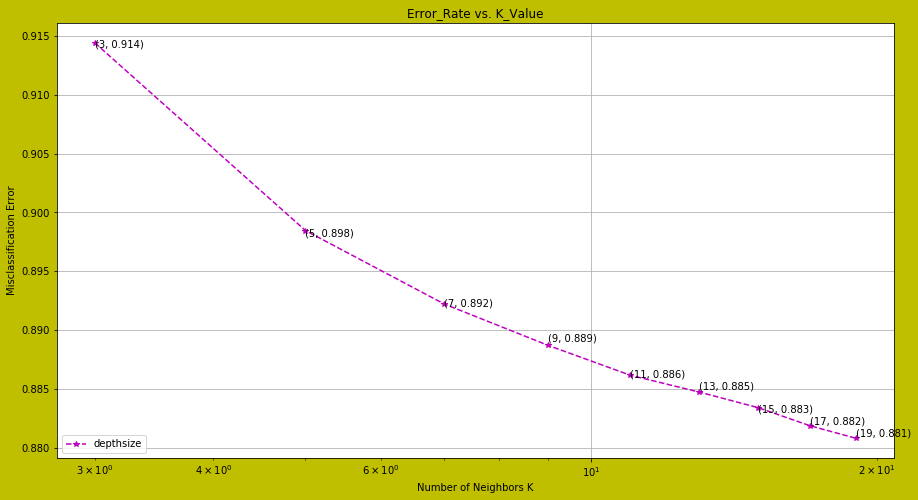

the misclassification error for each k value is :  [0.91441 0.89846 0.89222 0.88871 0.88616 0.88473 0.8834  0.88187 0.88081]


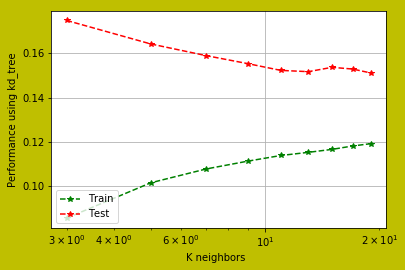

algorithm =  brute

The optimal number of neighbors is 19.


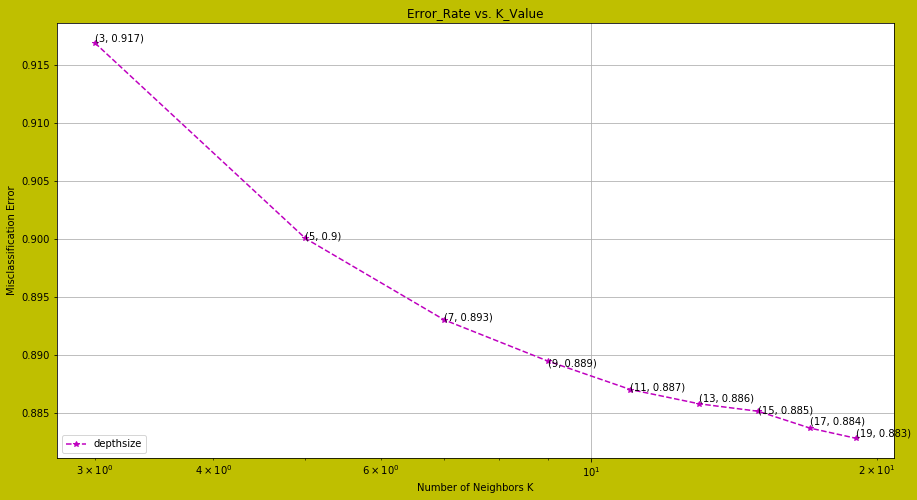

the misclassification error for each k value is :  [0.91691 0.90007 0.89305 0.8895  0.88704 0.88581 0.88517 0.88372 0.88284]


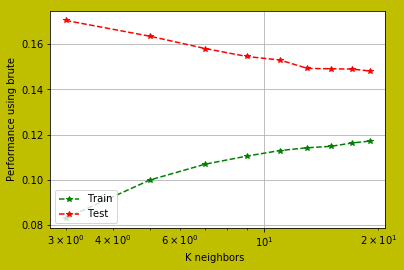

In [61]:
if __name__=='__main__':
    mp.freeze_support()
   
    xtrain=[final_w2v_count_Train_sparse,final_w2v_count_Train]
    xtest=[final_w2v_count_Test_sparse,final_w2v_count_Test]

    main()

#### Observations
* The optimal number of neighbors is 19 for avg word2vec for both the algorithm.
* MSE(Misclassification error) is descreasing when k values is increasing  as seen in graph.
* In performance graph, lowest k value gives higest error in test datasets. As k value increase, testing error gets reduces but vice -versa in case of traing datasets.


## Knn classifier  for optimal k value ( Avg word2vec)
All techniques for Scoring metrics and confusion matrix are shown as below

In [62]:
k=optimal_k_list
print(optimal_k_list)

[19, 19]


In [63]:
xtrain=[final_w2v_count_Train_sparse,final_w2v_count_Train]
ytrain=[y_train_new,Y_train_data]
xtest=[final_w2v_count_Test_sparse,final_w2v_count_Test]
ytest=[y_test_new,Y_test_data]
vectorization='Avg word2vec'

Started.
Algorithm is =kd_tree for optimal k =19
 Algorithm = kd_tree
training accuracy= 0.8197142857142857
training error is = 0.18028571428571427
Accuracy for KNN model  is =  0.7805
Testing error for KNN model is =  0.21950000000000003


             precision    recall  f1-score   support

          0       0.75      0.50      0.60      3934
          1       0.79      0.92      0.85      8066

avg / total       0.78      0.78      0.77     12000



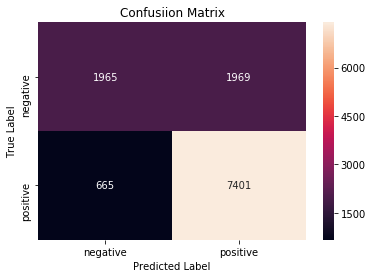

Algorithm is =brute for optimal k =19
 Algorithm = brute
training accuracy= 0.8238571428571428
training error is = 0.17614285714285716
Accuracy for KNN model  is =  0.78667
Testing error for KNN model is =  0.21333000000000002


             precision    recall  f1-score   support

   negative       0.75      0.53      0.62      3934
   positive       0.80      0.91      0.85      8066

avg / total       0.78      0.79      0.78     12000



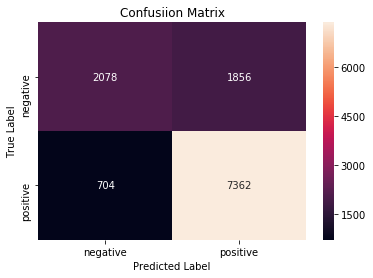

In [64]:
import multiprocessing as mp


def main1():
    print("Started.")
    algorithm=['kd_tree','brute']
  
    for i in range(len(algorithm)):
        algo=algorithm[i]
        print("Algorithm is ="+str(algo)+" for optimal k ="+str(k[i]))

        Knn_classifier_optimal_k(xtrain[i],ytrain[i],xtest[i],ytest[i],k[i],algo,vectorization)

if __name__=='__main__':
    mp.freeze_support()
    main1()
   


In [65]:
df4=pd.DataFrame(models_performence, columns=columns)
result_display(df4)

|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW         |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|
|KNN  |Avg word2vec|kd_tree  |       19|     0.1803|    0.2195|  0.7805|72.38| 70.85|    76.85|
|KNN  |Avg word2vec|brute    |       19|     0.1761|    0.2133|  0.7867|73.53| 72.05|    77.28|



|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2895|    0.3299|  0.6701|40.79| 50.04|    51.33|
|KNN  |BOW         |brute    |       19|     0.2895|    0.3299|  0.6701|40.79| 50.04|    51.33|
|KNN  |Avg word2vec|kd_tree  |       19|     0.2875|    0.3368|  0.6632|42.09| 49.98|    49.82|
|KNN  |Avg word2vec|brute    |       19|     0.2875|    0.3368|  0.6632|42.09| 49.98|    49.82|

#### observations
* The optimal number of neighbors is 19 for both the algorithm for avg word2vec model.
* True postive rate   is high(91%) for Brute force and 92% for KD-Tree.It means postive rating is higher as compared to negative rating which is good for amazon reviews .
* Confusion matrix and model performance is shown as above.
* TNR and FNR is almost similar  in both Algorithm.FNR is high.Almost 50% of negative (3934 negative words )are predicting as postive 
* It means models performance is poor as negative reviews is showing as postive reviews.
* KDTree Algorithm for KNN classifier is giving better performance as compared to brute Algorithm  as seen in above table



 

# 3. TF-IDF


In [66]:
##### TF-IDF for Training data

In [60]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf11 = tf_idf_vect.fit_transform(X_train_data.values.ravel())
final_tf_idf11.get_shape()
tfidf_feat = tf_idf_vect.get_feature_names() 

In [61]:
features = tf_idf_vect.get_feature_names()
len(features)

493611

In [62]:
final_tf_idf=svd.fit_transform(final_tf_idf11 )
print("TruncatedSVD :",final_tf_idf.shape)


TruncatedSVD : (28000, 100)


#### Dumping & Loading Pickle file for training data (TF-IDF)

In [70]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
X_train_data_tfidf=open(pickle_path_tfidf_train,'wb')
pickle.dump(final_tf_idf ,X_train_data_tfidf)
X_train_data_tfidf.close()

In [63]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
unpickle_path5=open(pickle_path_tfidf_train,'rb')
final_tf_idf=pickle.load(unpickle_path5)

In [64]:
#StandardScaleing and normalizing training Tf-IDF
sc_data2= StandardScaler(with_mean=False).fit_transform(final_tf_idf)
final_tfidf_np= preprocessing.normalize(sc_data2)
print("Train Data: ",final_tfidf_np.shape)


warnings.filterwarnings("ignore")    

Train Data:  (28000, 100)


In [73]:
# Sparse matrix for Tf-IDF
final_tf_idf_sparse=csr_matrix(final_tf_idf).todense()

print("Train data Sparse:",final_tf_idf_sparse.shape)

Train data Sparse: (28000, 100)


##### tf-idf For Testing datasets 

In [65]:
final_tf_idf_test1_svd = tf_idf_vect.transform(X_test_data.values.ravel())
final_tf_idf_test1_svd.get_shape()

(12000, 493611)

In [66]:
svd1 = svd.fit(final_tf_idf_test1_svd)

final_tf_idf_test1=svd1.transform(final_tf_idf_test1_svd)
print("TruncatedSVD :",final_tf_idf_test1.shape)
#Normalize Data
#X_sparse_tsvd = svd.fit(vect_Data1).transform(X_sparse)

TruncatedSVD : (12000, 100)


#### Dumping & Loading Pickle file for testing data(TF-IDF)

In [76]:

pickle_path_tfidf_test='X_test_data_tfidf.pkl'
X_test_data_tfidf=open(pickle_path_tfidf_test,'wb')
pickle.dump(final_tf_idf_test1 ,X_test_data_tfidf)
X_test_data_tfidf.close()

In [67]:
pickle_path_tfidf_test='X_test_data_tfidf.pkl'
unpickle_path6=open(pickle_path_tfidf_test,'rb')
final_tf_idf_test1=pickle.load(unpickle_path6)

In [68]:
final_tf_idf_test1_f=StandardScaler(with_mean=False).fit(final_tf_idf_test1 )
print(final_tf_idf_test1_f)

final_tf_idf_test11=final_tf_idf_test1_f.transform(final_tf_idf_test1 )
#Normalize Data
final_tfidf_np_test= preprocessing.normalize(final_tf_idf_test11)
print("Test Data: ",final_tfidf_np_test.shape)



StandardScaler(copy=True, with_mean=False, with_std=True)
Test Data:  (12000, 100)


##### Sparse testing data for tf-idf

In [69]:
final_tfidf_np_test_sparse=csr_matrix(final_tf_idf_test1).todense()

print("Test Data Sparse:",final_tfidf_np_test_sparse.shape)

Test Data Sparse: (12000, 100)


For Training :

                1.final_tfidf_np
                2.final_tf_idf_sparse
    
For Testing :

                1.final_tfidf_np_test
                2.final_tfidf_np_test_sparse

    
    

## optimal k using TF-IDF

Started.
opyimal k value
algorithm =  kd_tree

The optimal number of neighbors is 19.


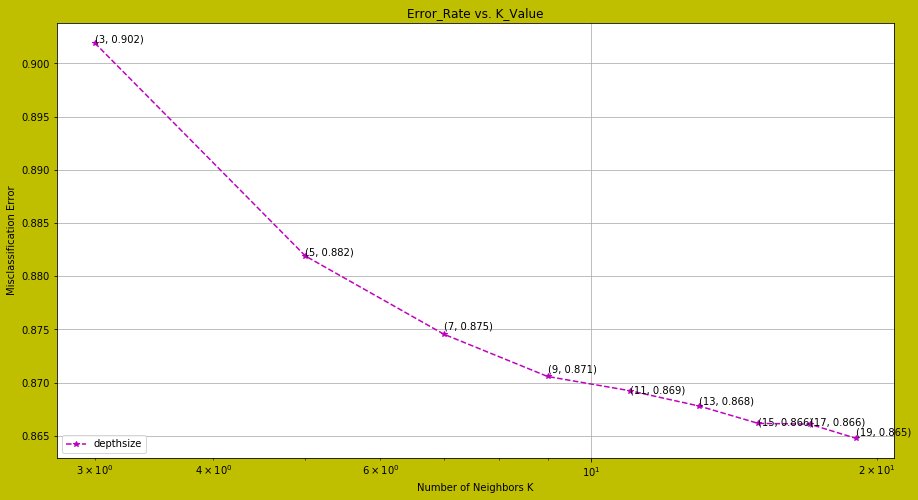

the misclassification error for each k value is :  [0.90194 0.88191 0.87455 0.87058 0.86924 0.8678  0.86618 0.8661  0.86478]


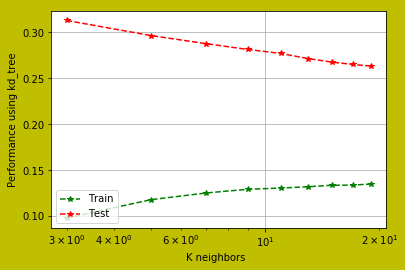

algorithm =  brute

The optimal number of neighbors is 19.


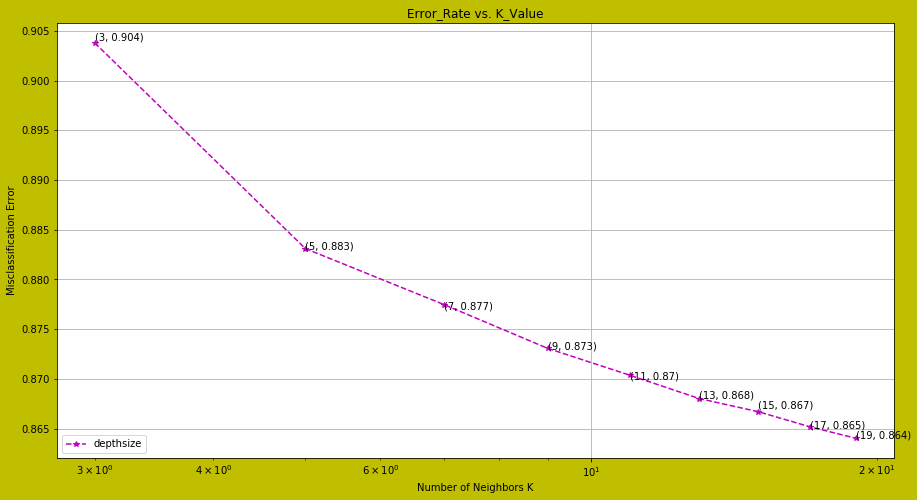

the misclassification error for each k value is :  [0.90378 0.88311 0.87747 0.87308 0.87036 0.86803 0.86671 0.8652  0.86404]


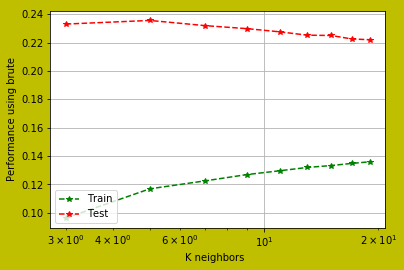

In [80]:
# To get optimal k using TF-IDF
if __name__=='__main__':
    mp.freeze_support()
   
    xtrain=[final_tf_idf_sparse,final_tfidf_np]
    
    xtest=[final_tfidf_np_test_sparse,final_tfidf_np_test]

    main()

## Knn classifier  for optimal k value ( TF-IDF)

All techniques for Scoring metrics and confusion matrix are shown as below

In [81]:
k=optimal_k_list
print(optimal_k_list)

[19, 19]


In [82]:
#KNN with Optimal K
xtrain=[final_tf_idf_sparse,final_tfidf_np]
ytrain=[y_train_new,Y_train_data]
xtest=[final_tfidf_np_test_sparse,final_tfidf_np_test]
ytest=[y_test_new,Y_test_data]
vectorization=' TF-IDF'


Started.
Algorithm is =kd_tree for optimal k =19
 Algorithm = kd_tree
training accuracy= 0.7994285714285714
training error is = 0.20057142857142862
Accuracy for KNN model  is =  0.61
Testing error for KNN model is =  0.39


             precision    recall  f1-score   support

          0       0.34      0.20      0.25      3934
          1       0.67      0.81      0.74      8066

avg / total       0.56      0.61      0.58     12000



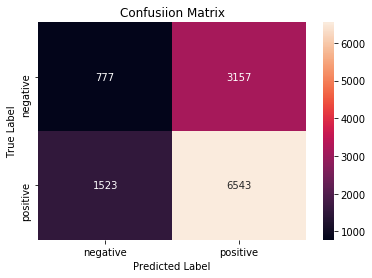

Algorithm is =brute for optimal k =19
 Algorithm = brute
training accuracy= 0.7911071428571429
training error is = 0.2088928571428571
Accuracy for KNN model  is =  0.64658
Testing error for KNN model is =  0.35341999999999996


             precision    recall  f1-score   support

   negative       0.34      0.08      0.13      3934
   positive       0.67      0.92      0.78      8066

avg / total       0.56      0.65      0.57     12000



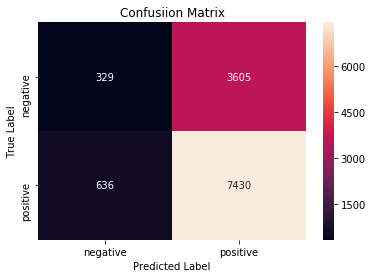

In [83]:
import multiprocessing as mp


def main1():
    print("Started.")
    algorithm=['kd_tree','brute']
  
    for i in range(len(algorithm)):
        algo=algorithm[i]
        print("Algorithm is ="+str(algo)+" for optimal k ="+str(k[i]))

        Knn_classifier_optimal_k(xtrain[i],ytrain[i],xtest[i],ytest[i],k[i],algo,vectorization)

if __name__=='__main__':
    mp.freeze_support()
    main1()
   


In [84]:
df6=pd.DataFrame(models_performence, columns=columns)
result_display(df6)

|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW         |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|
|KNN  |Avg word2vec|kd_tree  |       19|     0.1803|    0.2195|  0.7805|72.38| 70.85|    76.85|
|KNN  |Avg word2vec|brute    |       19|     0.1761|    0.2133|  0.7867|73.53| 72.05|    77.28|
|KNN  | TF-IDF     |kd_tree  |       19|     0.2006|    0.3900|  0.6100|49.29| 50.43|    50.62|
|KNN  | TF-IDF     |brute    |       19|     0.2089|    0.3534|  0.6466|45.61| 50.24|    50.71|



In [85]:
pickle_path111='df6.pkl'
df61=open(pickle_path111,'wb')
pickle.dump(df6,df61)
df61.close()

In [44]:
pickle_path111='df6.pkl'
unpickle_path6=open(pickle_path111,'rb')
df611=pickle.load(unpickle_path6)

In [45]:
df6=pd.DataFrame(models_performence, columns=columns)
result_display(df611)

|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW         |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|
|KNN  |Avg word2vec|kd_tree  |       19|     0.1803|    0.2195|  0.7805|72.38| 70.85|    76.85|
|KNN  |Avg word2vec|brute    |       19|     0.1761|    0.2133|  0.7867|73.53| 72.05|    77.28|
|KNN  | TF-IDF     |kd_tree  |       19|     0.2006|    0.3900|  0.6100|49.29| 50.43|    50.62|
|KNN  | TF-IDF     |brute    |       19|     0.2089|    0.3534|  0.6466|45.61| 50.24|    50.71|



|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW         |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|
|KNN  |Avg word2vec|kd_tree  |       19|     0.1803|    0.2195|  0.7805|72.38| 70.85|    76.85|
|KNN  |Avg word2vec|brute    |       19|     0.1761|    0.2133|  0.7867|73.53| 72.05|    77.28|
|KNN  | TF-IDF     |kd_tree  |       19|     0.2006|    0.3900|  0.6100|49.29| 50.43|    50.62|
|KNN  | TF-IDF     |brute    |       19|     0.2089|    0.3534|  0.6466|45.61| 50.24|    50.71|

#### observations
* The optimal number of neighbors is 19 for both the algorithm for TF-IDf model.
* True postive rate   is high(92%) for Brute force and 81% for KD-Tree.It means postive rating is higher as compared to negative rating which is good for amazon reviews .
* Confusion matrix and model performance is shown as above.

* KDTree Algorithm for KNN classifier is giving better performance as compared to brute Algorithm  as seen in above table



 
    

#  4.TF-IDF weighted Word2Vec

In [70]:
tfidf_feat = tf_idf_vect.get_feature_names() 


In [71]:
# TF-IDF weighted Word2Vec
#tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors  = []; 
row=0;
for sent in  X_train_data.values.ravel() : 
    sent_vec = np.zeros(100) 
    weight_sum =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors .append(sent_vec)
    row += 1

In [72]:
print(len(tfidf_sent_vectors))

28000


In [73]:
print(tfidf_sent_vectors[2])
tfidf_sent_vectors_train  = np.where(np.isnan(tfidf_sent_vectors ), 0, tfidf_sent_vectors )
print(tfidf_sent_vectors_train[2])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [74]:
tfidf_sent_vectors_train  = np.asarray(tfidf_sent_vectors_train )
print(type(tfidf_sent_vectors))

<class 'list'>


#### Dumping & Loading Pickle file for trainText data (TF-IDF weighted word2vec)

In [75]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
X_data_tfidf_weighted=open(pickle_path_tfidf_weighted,'wb')
pickle.dump(tfidf_sent_vectors_train  ,X_data_tfidf_weighted)
X_data_tfidf_weighted.close()

In [76]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
unpickle_path7=open(pickle_path_tfidf_weighted,'rb')
tfidf_sent_vectors_train =pickle.load(unpickle_path7)

In [77]:
sc_data3= StandardScaler(with_mean=False).fit_transform(tfidf_sent_vectors_train)
final_tfidf_w2v_np_train=preprocessing.normalize(sc_data3)

##### For test Tf-idf weighted word2vec

In [78]:
tfidf_sent_vectors1  = []; 
row=0;
for sent in  X_test_data.values.ravel() : 
    sent_vec = np.zeros(100) 
    weight_sum =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            
            tfidf = final_tf_idf_test1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors1 .append(sent_vec)
    row += 1

In [79]:
print(len(tfidf_sent_vectors1))
print(tfidf_sent_vectors1[2])
tfidf_sent_vectors_test  = np.where(np.isnan(tfidf_sent_vectors1 ),
                                     0, tfidf_sent_vectors1 )
print(tfidf_sent_vectors_test[2])
final_tfidf_w2v_np_test = np.asarray(tfidf_sent_vectors_test )
print(type(tfidf_sent_vectors1))

12000
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
<class 'list'>


#### Dumping & Loading Pickle file for test Text data (TF-IDF weighted word2vec)

In [80]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
X_data_tfidf_weighted1=open(pickle_path_tfidf_weighted1,'wb')
pickle.dump(final_tfidf_w2v_np_test  ,X_data_tfidf_weighted1)
X_data_tfidf_weighted1.close()

In [81]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
unpickle_path71=open(pickle_path_tfidf_weighted1,'rb')
final_tfidf_w2v_np_test =pickle.load(unpickle_path71)

In [82]:
final_tfidf_np_test_sparse=csr_matrix(final_tf_idf_test1).todense()

print("Test Data Sparse:",final_tfidf_np_test_sparse.shape)

Test Data Sparse: (12000, 100)


#### Sparse Matrix for Training And Testing TF-IDF weighted avg word2vec

In [83]:
final_tfidf_w2v_np_train_sparse=csr_matrix(tfidf_sent_vectors_train).todense()

print("Train data Sparse:",final_tfidf_w2v_np_train_sparse.shape)

Train data Sparse: (28000, 100)


In [84]:
final_tfidf_w2v_np_test_sparse=csr_matrix(tfidf_sent_vectors_test ).todense()

print("Test Data Sparse:",final_tfidf_w2v_np_test_sparse.shape)

Test Data Sparse: (12000, 100)


for Training Data:

            1.final_tfidf_w2v_np_train_sparse
            2.final_tfidf_w2v_np_train

For testing data:

            1.final_tfidf_w2v_np_test_sparse
            2.final_tfidf_w2v_np_test
    

## optimal k using TF-IDF weighted Word2Vec

Started.
opyimal k value
algorithm =  kd_tree

The optimal number of neighbors is 3.


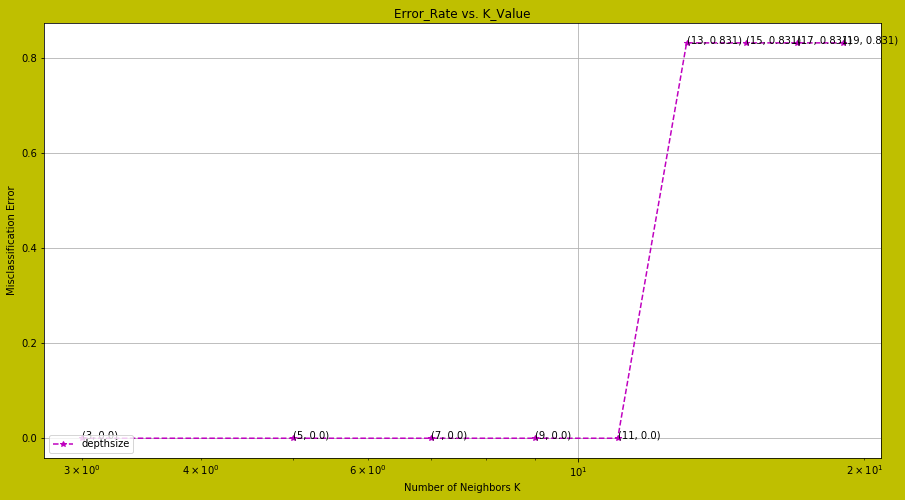

the misclassification error for each k value is :  [0.      0.      0.      0.      0.      0.83134 0.83134 0.83134 0.83134]


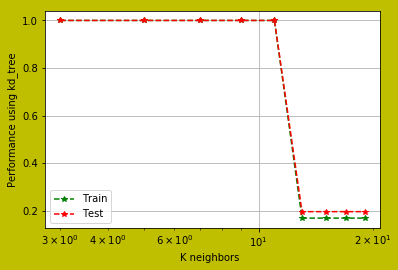

algorithm =  brute

The optimal number of neighbors is 3.


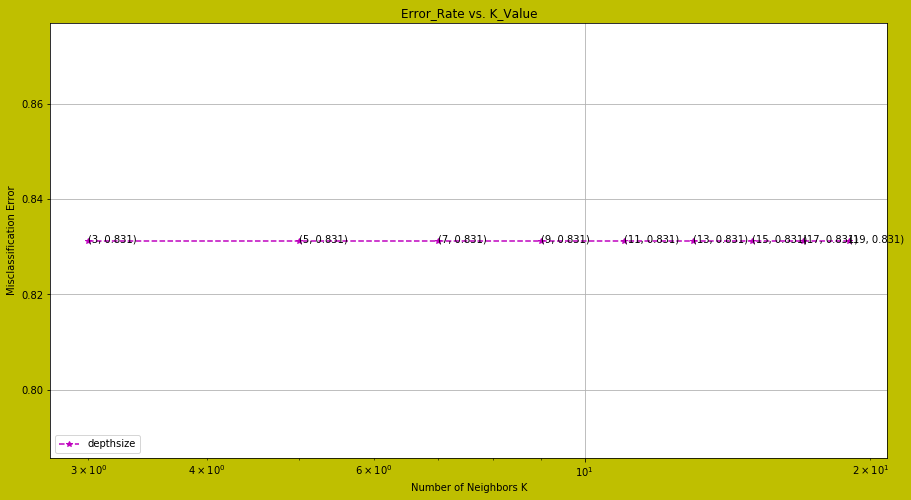

the misclassification error for each k value is :  [0.83134 0.83134 0.83134 0.83134 0.83134 0.83134 0.83134 0.83134 0.83134]


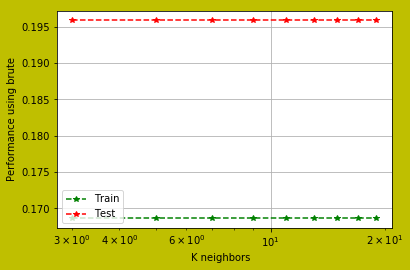

In [85]:
# To get optimal k using Tf-IDf weighted Word2Vec

if __name__=='__main__':
    mp.freeze_support()
    xtrain=[final_tfidf_w2v_np_train_sparse,final_tfidf_w2v_np_train]
    xtest=[final_tfidf_w2v_np_test_sparse,final_tfidf_w2v_np_test]

    main()



#### Observations:
* The optimal number of neighbors is 3
* The graph is constant for all values of k 
* MSE graph and performance graph for avg word2 vec and TF-IDF weighted word2vec is shown above.   

## Knn classifier  for optimal k value ( TF-IDF weighted word2vec)

In [86]:
k=optimal_k_list
print(k)

[3, 3]


In [87]:
#KNN with Optimal K
xtrain=[final_tfidf_w2v_np_train_sparse,final_tfidf_w2v_np_train]
ytrain=[y_train_new,Y_train_data]
xtest=[final_tfidf_w2v_np_test_sparse,final_tfidf_w2v_np_test]
ytest=[y_test_new,Y_test_data]


vectorization=' TF-IDF weighted word2vec'



Started.
Algorithm is =kd_tree for optimal k =3
 Algorithm = kd_tree
training accuracy= 0.28864285714285715
training error is = 0.7113571428571428
Accuracy for KNN model  is =  0.32758
Testing error for KNN model is =  0.67242


             precision    recall  f1-score   support

          0       0.33      1.00      0.49      3931
          1       0.00      0.00      0.00      8069

avg / total       0.11      0.33      0.16     12000



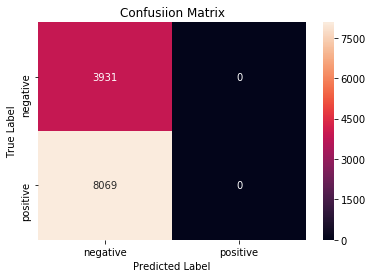

Algorithm is =brute for optimal k =3
 Algorithm = brute
training accuracy= 0.7113571428571429
training error is = 0.2886428571428571
Accuracy for KNN model  is =  0.67242
Testing error for KNN model is =  0.32758


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      3931
   positive       0.67      1.00      0.80      8069

avg / total       0.45      0.67      0.54     12000



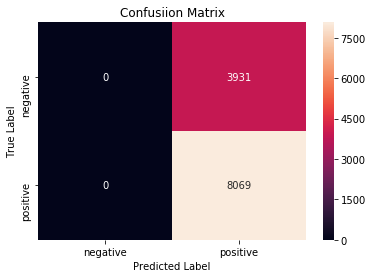

In [88]:
import multiprocessing as mp


def main1():
    print("Started.")
    algorithm=['kd_tree','brute']
  
    for i in range(len(algorithm)):
        algo=algorithm[i]
        print("Algorithm is ="+str(algo)+" for optimal k ="+str(k[i]))

        Knn_classifier_optimal_k(xtrain[i],ytrain[i],xtest[i],ytest[i],k[i],algo,vectorization)

if __name__=='__main__':
    mp.freeze_support()
    main1()
   


In [89]:
df8=pd.DataFrame(models_performence, columns=columns)
result_display(df8)

|Model|       Vectorizer        |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|-------------------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  | TF-IDF weighted word2vec|kd_tree  |        3|     0.7114|    0.6724|  0.3276|24.67|    50|    16.38|
|KNN  | TF-IDF weighted word2vec|brute    |        3|     0.2886|    0.3276|  0.6724|40.21|    50|    33.62|



In [90]:
print(df8)

  Model                 Vectorizer algorithm  Optimal k  Train error  \
0   KNN   TF-IDF weighted word2vec   kd_tree          3     0.711357   
1   KNN   TF-IDF weighted word2vec     brute          3     0.288643   

   Test error  Accuracy      F1  recall  precision  
0     0.67242   0.32758  24.675    50.0     16.379  
1     0.32758   0.67242  40.206    50.0     33.621  


# Conclusions

|Model| Vectorizer |algorithm|Optimal k|Train error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|---------|--------:|----------:|---------:|-------:|----:|-----:|--------:|
|KNN  |BOW         |kd_tree  |       19|     0.2198|    0.3731|  0.6269|49.28| 51.03|    51.72|
|KNN  |BOW         |brute    |       19|     0.2212|    0.3562|  0.6437|46.45| 50.43|    51.12|
|KNN  |Avg word2vec|kd_tree  |       19|     0.1803|    0.2195|  0.7805|72.38| 70.85|    76.85|
|KNN  |Avg word2vec|brute    |       19|     0.1761|    0.2133|  0.7867|73.53| 72.05|    77.28|
|KNN  | TF-IDF     |kd_tree  |       19|     0.2006|    0.3900|  0.6100|49.29| 50.43|    50.62|
|KNN  | TF-IDF     |brute    |       19|     0.2089|    0.3534|  0.6466|45.61| 50.24|    50.71|
|KNN  | TF-IDF weighted word2vec|kd_tree  |        3|     0.7114|    0.6724|  0.3276|24.67|    50|    16.38|
|KNN  | TF-IDF weighted word2vec|brute    |        3|     0.2886|    0.3276|  0.6724|40.21|    50|    33.62|


* MSE(misclassification error) and optimal value of k is same for KdTree and Brute force in weighted tf-idf featurization technique.
* Training error for Tf-idf is low but testing error is too high in case of KDtree. In other vectorizer techniques training and testing error is quite similar.
* Model Tf-IDF weighted tf-idf using KDTree algorithm leads to overfitting.
* From above Table,It can be concluded that KNN model works best in case of Bag of words which is the best to predict the polarity of reviews among all models.
* All techniques for scoring metrics is good in case for BOW for given KNN model.
* The kd-tree and brute implementation of KNN for all featurization techniques  gives relatively similar results.
* For getting K optimal values, f1 score and precision score metrics techniques doesnot work in KNN classifier. Only accuracy metrics gives relative optimal K-values.
* From all featurization techniques, BOW & Avg word2vec gives better results in both the implementations while Tf-IDF and TF-IDF weighted word2vec does not perform well.
* K-value for featurization techniques  varies if dimesions(features) increases 

* Avg word2vec for KNN(KDtree and Brute) performs very well for classifying given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2))  



